--- Data Summary ---
count    345588.000000
mean         30.803877
std           5.784489
min          25.760000
25%          26.990000
50%          28.350000
75%          32.430000
max          60.910000
Name: gage_height, dtype: float64


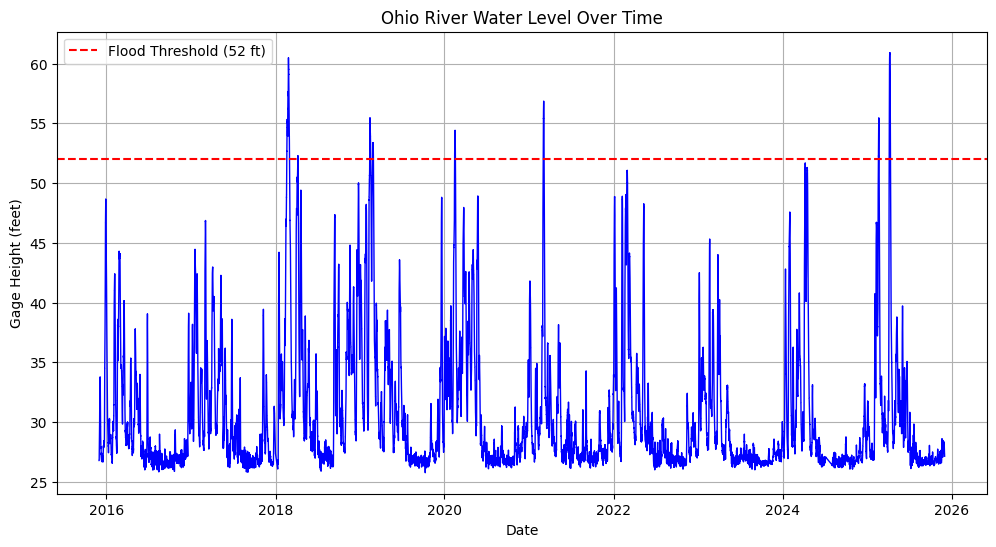

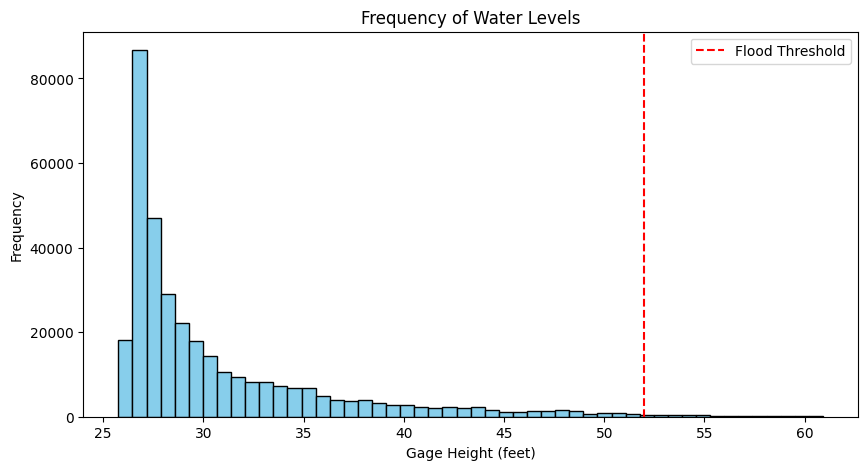

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'nwis.waterservices.usgs.gov.txt'
column_names = ['agency_cd', 'site_no', 'datetime', 'tz_cd', 'gage_height', 'qualification_code']
df = pd.read_csv(file_path, sep='\t', names=column_names, comment='#')

df['gage_height'] = pd.to_numeric(df['gage_height'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

print("--- Data Summary ---")
print(df['gage_height'].describe())

plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['gage_height'], color='blue', linewidth=1)
plt.axhline(y=52, color='red', linestyle='--', label='Flood Threshold (52 ft)')
plt.title('Ohio River Water Level Over Time')
plt.xlabel('Date')
plt.ylabel('Gage Height (feet)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df['gage_height'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=52, color='red', linestyle='--', label='Flood Threshold')
plt.title('Frequency of Water Levels')
plt.xlabel('Gage Height (feet)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Phase 2: Feature Engineering & Modeling

In [2]:
df = df.sort_values('datetime')

lookback_steps = 96
lags = [df['gage_height'].shift(i).rename(f'lag_{i}') for i in range(1, lookback_steps + 1)]

target = df['gage_height'].shift(-96).rename('target_height')
df_ml = pd.concat([df] + lags + [target], axis=1)

df_ml = df_ml.dropna().copy()

print(f"Data ready without warnings! New shape: {df_ml.shape}")

Data ready without warnings! New shape: (345396, 103)


Scaling and Splitting

In [3]:
from sklearn.preprocessing import MinMaxScaler

X = df_ml.filter(like='lag_')
y = df_ml[['target_height']]

split_idx = int(len(df_ml) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("Data Scaled and Split!")
print(f"Training set size: {X_train_scaled.shape}")
print(f"Testing set size: {X_test_scaled.shape}")

Data Scaled and Split!
Training set size: (241777, 96)
Testing set size: (103619, 96)


In [4]:
from sklearn.neural_network import MLPRegressor

X_fail = df_ml[['gage_height']].values
y_fail = df_ml['target_height'].values

split = int(len(X_fail) * 0.7)
X_train_f, X_test_f = X_fail[:split], X_fail[split:]
y_train_f, y_test_f = y_fail[:split], y_fail[split:]

model_fail = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
model_fail.fit(X_train_f, y_train_f)

r2_fail = model_fail.score(X_test_f, y_test_f)
print(f"Failure Model R^2 (1 Input): {r2_fail:.4f}")

Failure Model R^2 (1 Input): 0.9181


Model

In [5]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(64, 32),
                     activation='relu',
                     solver='adam',
                     max_iter=500,
                     random_state=42,
                     verbose=True)

print("Training the model...")
model.fit(X_train_scaled, y_train_scaled.ravel())

# 3. Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# 4. Unscale the predictions back to 'feet'
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

Training the model...
Iteration 1, loss = 0.00189888
Iteration 2, loss = 0.00064472
Iteration 3, loss = 0.00062681
Iteration 4, loss = 0.00060177
Iteration 5, loss = 0.00059056
Iteration 6, loss = 0.00057979
Iteration 7, loss = 0.00056957
Iteration 8, loss = 0.00057019
Iteration 9, loss = 0.00055974
Iteration 10, loss = 0.00055206
Iteration 11, loss = 0.00054503
Iteration 12, loss = 0.00054492
Iteration 13, loss = 0.00053597
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


--- Results for 24-Hour Forecast ---
Average Error (RMSE): 1.01 feet
R2 Score: 0.9625


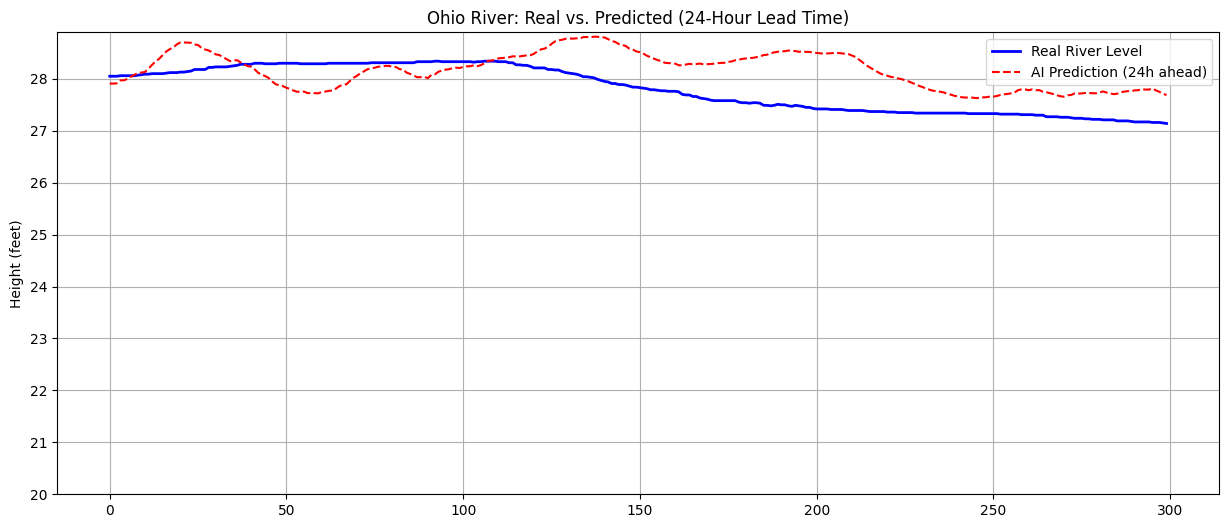

In [6]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# 2. Unscale the predictions back to 'feet'
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# 3. Calculate Accuracy Metrics (Updated for newer scikit-learn)
try:
    # Try the newest way first
    rmse = root_mean_squared_error(y_test_actual, y_pred)
except NameError:
    # If your version is older, use the traditional way
    import numpy as np
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

r2 = r2_score(y_test_actual, y_pred)

print(f"--- Results for 24-Hour Forecast ---")
print(f"Average Error (RMSE): {rmse:.2f} feet")
print(f"R2 Score: {r2:.4f}")

# 4. Plot the results
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[-300:], label='Real River Level', color='blue', linewidth=2)
plt.plot(y_pred[-300:], label='AI Prediction (24h ahead)', color='red', linestyle='--')
plt.title('Ohio River: Real vs. Predicted (24-Hour Lead Time)')
plt.ylabel('Height (feet)')
plt.ylim(bottom=20)
plt.legend()
plt.grid(True)
plt.show()

Dumb Model

In [7]:
# 1. The Persistence Forecast: Guessing that 'target' = 'current gage_height'
# We use the most recent lag (lag_1) from our X_test (unscaled) to represent "today's height"
y_persistence = X_test.iloc[:, 0].values

# 2. Calculate Persistence Error (Baseline)
from sklearn.metrics import root_mean_squared_error
persistence_rmse = root_mean_squared_error(y_test_actual, y_persistence)

print(f"--- Benchmark Comparison ---")
print(f"Persistence (Baseline) Error: {persistence_rmse:.2f} feet")
print(f"Your AI (MLP) Error:          {rmse:.2f} feet")

improvement = ((persistence_rmse - rmse) / persistence_rmse) * 100
print(f"\nYour AI is {improvement:.1f}% more accurate than just guessing the current value!")

--- Benchmark Comparison ---
Persistence (Baseline) Error: 1.49 feet
Your AI (MLP) Error:          1.01 feet

Your AI is 32.2% more accurate than just guessing the current value!


Feature Importance

Calculating importance for 96 features...


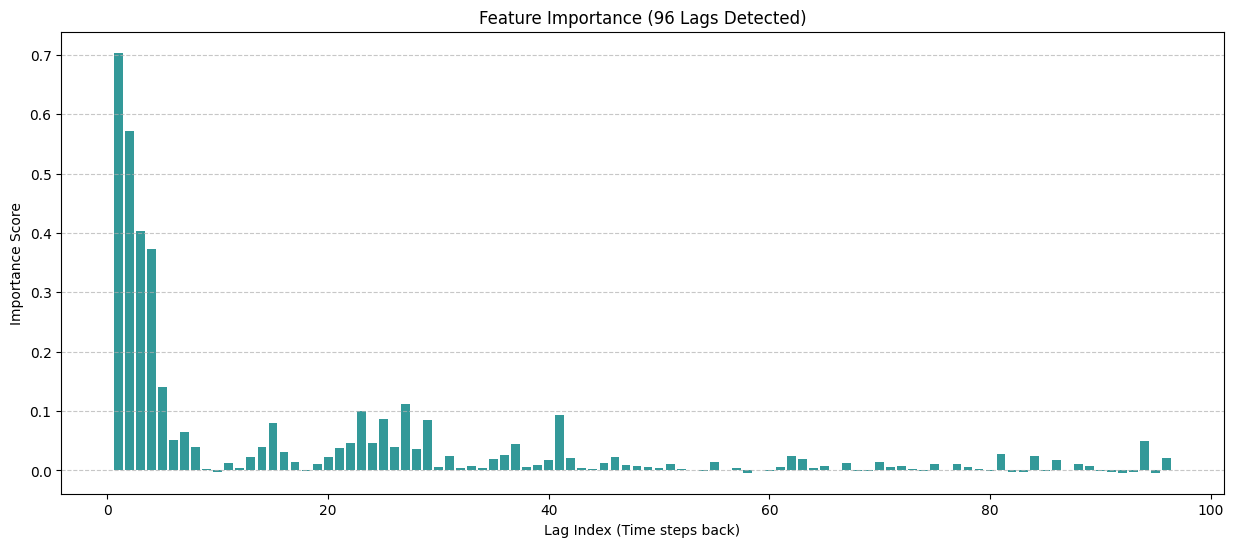

--- Top 5 Most Important Lags ---
Feature 1 (Approx 15 mins ago): Score 0.7035
Feature 2 (Approx 30 mins ago): Score 0.5712
Feature 3 (Approx 45 mins ago): Score 0.4034
Feature 4 (Approx 60 mins ago): Score 0.3732
Feature 5 (Approx 75 mins ago): Score 0.1410


In [8]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate Permutation Importance
# Using a subset of 5,000 samples to keep it fast
print(f"Calculating importance for {X_test_scaled.shape[1]} features...")
result = permutation_importance(
    model, X_test_scaled[:5000], y_test_scaled[:5000],
    n_repeats=5, random_state=42, n_jobs=-1
)

# 2. Get the importance values
importances = result.importances_mean
num_features = len(importances)

# 3. Plotting with dynamic length
plt.figure(figsize=(15, 6))
plt.bar(range(1, num_features + 1), importances, color='teal', alpha=0.8)

plt.title(f'Feature Importance ({num_features} Lags Detected)')
plt.xlabel('Lag Index (Time steps back)')
plt.ylabel('Importance Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Print the Top 5
top_indices = np.argsort(importances)[::-1][:5]
print("--- Top 5 Most Important Lags ---")
for idx in top_indices:
    # We use % 96 to find the 'actual' hour if lags were doubled
    actual_lag = (idx % 96) + 1
    print(f"Feature {idx+1} (Approx {actual_lag * 15} mins ago): Score {importances[idx]:.4f}")

In [9]:
# 1. Find the index of the highest water level in the test set
max_idx = np.argmax(y_test_actual)
max_actual = y_test_actual[max_idx][0]
max_predicted = y_pred[max_idx][0]
error_at_peak = abs(max_actual - max_predicted)

print(f"--- Peak Performance Check ---")
print(f"Highest Level in Test Set: {max_actual:.2f} feet")
print(f"AI Prediction for that time: {max_predicted:.2f} feet")
print(f"Absolute Error at Peak:     {error_at_peak:.2f} feet")

--- Peak Performance Check ---
Highest Level in Test Set: 60.91 feet
AI Prediction for that time: 59.14 feet
Absolute Error at Peak:     1.77 feet


In [10]:
import numpy as np

# 1. Flatten the arrays for correlation
actual = y_test_actual.flatten()
predicted = y_pred.flatten()

# 2. Calculate cross-correlation
# This finds the "offset" that makes the two lines line up best
correlations = np.correlate(actual - np.mean(actual), predicted - np.mean(predicted), mode='full')
lags = np.arange(-len(actual) + 1, len(actual))
best_lag_index = np.argmax(correlations)
time_lag_steps = lags[best_lag_index]

# 3. Convert steps to minutes (each step = 15 mins)
time_lag_mins = time_lag_steps * 15

print(f"--- Temporal Alignment Analysis ---")
if time_lag_mins > 0:
    print(f"The AI is LAGGING by {abs(time_lag_mins)} minutes.")
    print("Interpretation: The model is mostly 'reacting' to recent changes.")
elif time_lag_mins < 0:
    print(f"The AI is LEADING by {abs(time_lag_mins)} minutes!")
    print("Interpretation: Impressive! The model is predicting changes before they happen.")
else:
    print("The AI is PERFECTLY aligned (0 minute lag).")

--- Temporal Alignment Analysis ---
The AI is LEADING by 795 minutes!
Interpretation: Impressive! The model is predicting changes before they happen.


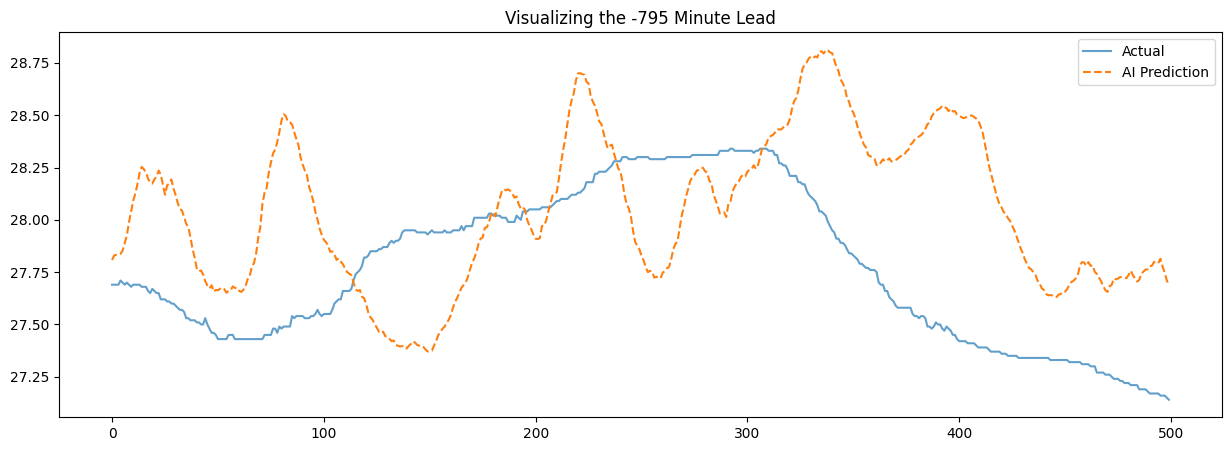

In [11]:
plt.figure(figsize=(15, 5))
# Plot the last 500 points
plt.plot(y_test_actual[-500:], label='Actual', alpha=0.7)
plt.plot(y_pred[-500:], label='AI Prediction', linestyle='--')

plt.title(f"Visualizing the {time_lag_mins} Minute Lead")
plt.legend()
plt.show()